# Обучение модели.
Когда завершён этап обработки данных, пора перейти к обучению модели.


## Установка нужных утилит.
Установим парочку библиотек для работы с матрицами, данными и нейронными сетями.
В условиях ограниченного времени, мы не будем разрабатывать и тестировать свои собственные решения, поэтому воспользуемя готовыми, оптимизированными и протестированными решениями.

In [1]:
%pip install numpy pandas torch torchinfo torcheval matplotlib

Note: you may need to restart the kernel to use updated packages.


## Полезные функции и импорты.

Для более выраженного и качественного кода.

In [2]:
# (Де-факто стандарт) Библиотека для работы с линейной алгеброй.
import numpy as np

# pandas - данные
import pandas as pd

# Torch - простое решение, с открытым исходным кодом.
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
# Для подведения итогов обучения.
from torchinfo import summary
from torcheval.metrics import MeanSquaredError

# Графики для анализа процесса обучения.
import matplotlib.pyplot as plt

In [3]:
%mkdir checkpoints/ checkpoints/model/ checkpoints/optimizer/

mkdir: невозможно создать каталог «checkpoints/»: Файл существует
mkdir: невозможно создать каталог «checkpoints/model/»: Файл существует
mkdir: невозможно создать каталог «checkpoints/optimizer/»: Файл существует


In [4]:
# Инициализация генератора псевдо-случаных чисел
generator = torch.Generator().manual_seed(73)
# Cuda - классная штука, когда она у тебя есть.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

/home/rushan/Projects/sirius/ii/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
device

device(type='cpu')

In [6]:
def split_dataset(dataset, fractions):
    """
    split_dataset(dataset, fractions)

    Разделить dataset на доли (процент от общей доли находиться в fractions)

    Аргументы:
    - dataset - разделяемый объект
    - fractions - коэффициенты на которые делим.
    """
    global generator
    return random_split(dataset, fractions, generator=generator)

In [7]:
def run(model, dataloader, loss_function, optimizer=None):
    """
    run(model, dataloader, loss_function, optimizer=None)

    Запустить (или обучить) модель и вернуть средний loss.

    Аргументы:
    - model - модель, которая будет запущена (или обучена)
    - dataloader - загрузчик.
    - loss_function - функция потерь для подсчета avg(total_loss)
    - optimizer=None - оптимизатор. Обучает модель, если значение не None.
    """
    global device

    if optimizer:
        model.train()
    else:
        model.eval()

    total_loss = 0
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        print(total_loss)
        if optimizer:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [8]:
from IPython.display import clear_output

def show_losses(train_loss_hist, test_loss_hist, clear=False):
    """
    show_losses(train_loss_hist, test_loss_hist, clear=False)

    Показывает графики изменения значений loss-a с течением времени (от количества эпох).

    Аргументы:
    - train_loss_hist, test_loss_hist - история значений train и test loss-ов
    - clear=False - флаг, определяющий очищать ли экран перед отрисовкой графиков.
    """
    if clear:
        clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [9]:
# Структуры, чтобы объединить разные объекты в одну сущность
# TrainValidLoader - два загрузчика, один для обучения, другой для валидации.
from dataclasses import dataclass


@dataclass
class TrainTestLoader:
    train_loader: DataLoader
    test_loader: DataLoader

In [10]:
def train_model(model, loss, optimizer,
                loaders: TrainTestLoader,
                model_name: str,
                num_epochs: int=20,
                show=True):
    """
    train_model(model, loss, optimizer,
                loaders: TrainTestLoader,
                num_epochs: int=20,
                show=True)


    Обучает данную модель по данному Loss и Optimizer на данной выборке.

    Аргументы:
    - model - обучаемая модель.
    - loss - функция потерь.
    - optimizer - оптимизатор. Метод поиска оптимума Loss.
    - loaders - загручики данных.
    - num_epochs=20 - количество эпох. (По умолчанию 20)
    - show=True - флаг, определяющий показывать ли графики обучения (по умолчанию True).
    """

    train_loss_hist = []
    test_loss_hist = []

    for i in range(num_epochs):
        print(i)
        train_loss = run(model, loaders.train_loader, loss, optimizer)
        print(train_loss)
        train_loss_hist.append(train_loss)
        test_loss = run(model, loaders.test_loader, loss)
        test_loss_hist.append(test_loss)

        if i % 10 == 9 and show:
            show_losses(train_loss_hist, test_loss_hist, clear=True)

        torch.save(model.state_dict(), f"checkpoints/model/{model_name}_{i}.pt")
        torch.save(optimizer.state_dict(), f'checkpoints/optimizer/{model_name}_{i}.pt')

    show_losses(train_loss_hist, test_loss_hist, clear=True)

In [11]:
def count_metric(model, dataloader, metric):
    global device
    model.eval()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        metric.update(model(X), y)
    return metric.compute().item()


def mean_squared_error(model, dataloader):
    return count_metric(model, dataloader, MeanSquaredError())


## Загрузка датасета.
На предыдущем этапе мы занялись анализом данных, теперь пора обучить на них модель.

In [12]:
import pandas as pd

data = pd.read_csv('result.csv')

In [13]:
data.head()

,price_doc,timestamp,full_sq,num_room,kitch_sq,state,area_m,raion_popul,university_top_20_raion,radiation_raion,full_all,metro_min_avto,big_road1_km,oil_urals,gdp_quart,cpi,balance_trade_growth,deposits_growth,rent_price_2room_eco,rent_price_1room_eco
0,5850000,2011-08-20,43,2.0,6.0,2.0,6.407578e+06,155572,0,False,86206,2.590241,1.422391,109.31,14313.7,354.0,10.1,0.009740,36.77,29.07
1,6000000,2011-08-23,34,2.0,6.0,2.0,9.589337e+06,115352,0,False,76284,0.936700,2.887377,109.31,14313.7,354.0,10.1,0.009740,36.77,29.07
2,5700000,2011-08-27,43,2.0,6.0,2.0,4.808270e+06,101708,0,True,101982,2.120999,0.647250,109.31,14313.7,354.0,10.1,0.009740,36.77,29.07
3,13100000,2011-09-01,89,2.0,6.0,2.0,1.258354e+07,178473,0,False,21155,1.489049,2.677824,111.29,14313.7,353.2,10.1,0.009607,37.73,30.63
4,16331452,2011-09-05,77,2.0,6.0,2.0,8.398461e+06,108171,0,True,28179,1.257186,1.721834,111.29,14313.7,353.2,10.1,0.018590,37.73,30.63


In [14]:
data['radiation_raion'] = data['radiation_raion'].astype(float)

In [15]:
data = data.drop(columns=['timestamp'])

In [16]:
target = torch.from_numpy(data['price_doc'].to_numpy(dtype=np.float32))
data = torch.from_numpy(data.drop(columns=['price_doc']).to_numpy(dtype=np.float32))

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, targets):
        self.dataframe = dataframe
        self.targets = targets

    def __getitem__(self, index):
        return self.dataframe[index], self.targets[index]

    def __len__(self):
        return len(self.dataframe)

In [18]:
dataset = CustomDataset(data, target / target.max())

In [19]:
dataset[0]

(tensor([4.3000e+01, 2.0000e+00, 6.0000e+00, 2.0000e+00, 6.4076e+06, 1.5557e+05,
         0.0000e+00, 0.0000e+00, 8.6206e+04, 2.5902e+00, 1.4224e+00, 1.0931e+02,
         1.4314e+04, 3.5400e+02, 1.0100e+01, 9.7403e-03, 3.6770e+01, 2.9070e+01]),
 tensor(0.2714))

In [20]:
# Делим основную выборку на два подмножества: 0.8 обучающая, 0.2 тестовая.
fractions = [0.8, 0.2]
train_dataset, test_dataset = split_dataset(dataset, fractions)

In [21]:
BATCH_SIZE = 50

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_test_loaders = TrainTestLoader(train_loader, test_loader)

In [22]:
class ModelA(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(18, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4, 1),
            nn.Flatten(start_dim=0)
        )

    def forward(self, X):
        return self.net(X)

In [23]:
model = ModelA()

for X, y in test_loader:
    print(model(X).shape)
    print(y.shape)
    break

torch.Size([50])
torch.Size([50])


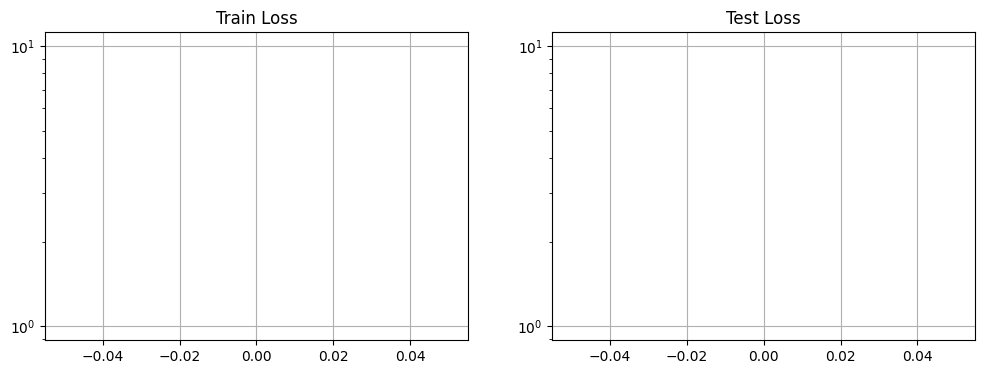

tensor(nan, grad_fn=<MseLossBackward0>)

In [31]:

model = ModelA()

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

train_model(model=model,
            loss=loss_function,
            optimizer=optimizer,
            loaders=train_test_loaders,
            model_name="Model A",
            num_epochs=10,
            show=True)
X, y = dataset[0]
loss_function(model(X), y)

In [25]:
mean_squared_error(model, test_loader)

nan

! Дополнение к итогу.
Модель не смогла обучиться, так как SGD сильно уносит в сторону, и она выдаёт сильно большие числа, из-за чего loss не становиться поточнее. 
Так, что модель не смогла обучиться. Точнее будет сказать она ушла в бесконечность, поэтому и результат обучения бесполезный. 

Для исправления ситуации не помогла нормализация.
Для решения задачи можно пересмотреть данные (возможно потеряли важные признаки и теперь нет зависимости).
Также можно попробовать другие оптимизаторы (код не буду силньо менять)